In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [ ]:
pip install py7zr

In [2]:
import py7zr

In [3]:
# Đường dẫn đến các file cần giải nén
train_file = '/kaggle/input/cifar-10/train.7z'
test_file = '/kaggle/input/cifar-10/test.7z'

# Đường dẫn thư mục để giải nén
train_output_dir = '/kaggle/working/train/'
test_output_dir = '/kaggle/working/test'

# Giải nén train.7z
with py7zr.SevenZipFile(train_file, mode='r') as z:
    z.extractall(path=train_output_dir)
print("Giải nén thành công train.7z")

# Giải nén test.7z
with py7zr.SevenZipFile(test_file, mode='r') as z:
    z.extractall(path=test_output_dir)
print("Giải nén thành công test.7z")

print("DONE!")


Giải nén thành công train.7z
Giải nén thành công test.7z
DONE!


In [4]:
import os

# Đường dẫn thư mục
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test'

# Đếm số tệp trong thư mục train
num_train_files = len([f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))])
print(f"Số tệp trong thư mục train: {num_train_files}")

# Đếm số tệp trong thư mục test
num_test_files = len([f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))])
print(f"Số tệp trong thư mục test: {num_test_files}")


Số tệp trong thư mục train: 50000
Số tệp trong thư mục test: 300000


In [5]:
train_labels = pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv")
sample_submissions = pd.read_csv("/kaggle/input/cifar-10/sampleSubmission.csv")

In [6]:
train_labels.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [7]:
train_labels.shape

(50000, 2)

In [8]:
sample_submissions.head()

,id,label
0,1,cat
1,2,cat
2,3,cat
3,4,cat
4,5,cat


In [9]:
sample_submissions.shape

(300000, 2)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from tqdm.auto import tqdm
from PIL import Image

In [11]:
# Chuyển mô hình sang device (GPU nếu có, CPU nếu không)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [13]:
from helper_functions import accuracy_fn

In [14]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [15]:
from pathlib import Path
train_dir = Path('/kaggle/working/train/train')
test_dir = Path('/kaggle/working/test/test')

In [16]:
walk_through_dir(train_dir)
walk_through_dir(test_dir)

There are 0 directories and 50000 images in '/kaggle/working/train/train'.
There are 0 directories and 300000 images in '/kaggle/working/test/test'.


### Visualize an image

50000
Random image path: /kaggle/working/train/train/17911.png
Root: train
Image height: 32
Image width: 32


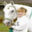

In [17]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(train_dir.glob("*.png"))
print(len(image_path_list))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_root = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Root: {image_root}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

### Transforming data

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [19]:
# Write transform for image
data_transform = transforms.Compose([
    # # Resize the images to 64x64
    # transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

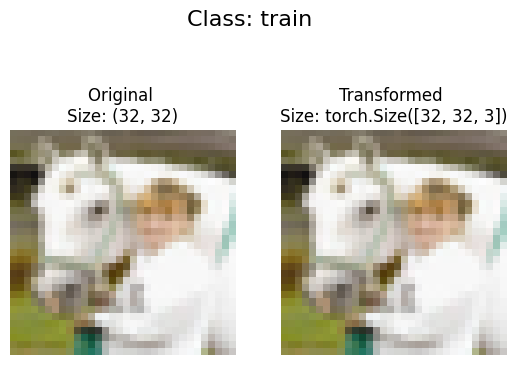

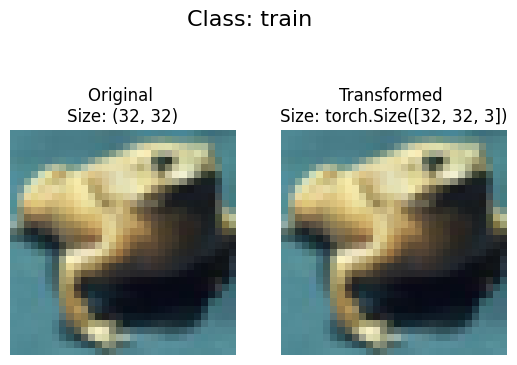

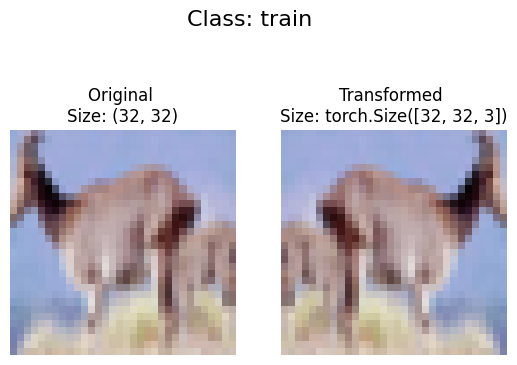

In [20]:
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### Custom Dataset

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
train_labels.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [23]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [24]:
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [25]:
train_labels["label"].unique()

array(['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship',
       'cat', 'dog', 'airplane'], dtype=object)

In [26]:
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [27]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
idx_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [28]:
train_labels['label_numeric'] = train_labels['label'].map(class_to_idx)
train_labels.head()

,id,label,label_numeric
0,1,frog,6
1,2,truck,9
2,3,truck,9
3,4,deer,4
4,5,automobile,1


In [29]:
labels = train_labels["label_numeric"]
labels

0        6
1        9
2        9
3        4
4        1
        ..
49995    2
49996    6
49997    9
49998    1
49999    1
Name: label_numeric, Length: 50000, dtype: int64

### Write a custom dataset

In [30]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, labels: pd.DataFrame, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all .png images and sort them by filename (numerically)
        self.paths = sorted(pathlib.Path(targ_dir).glob("*.png"), key=lambda x: int(x.stem))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = classes, class_to_idx
        # Set up labels
        self.labels = labels

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.labels["label"][index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [31]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [34]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      labels=train_labels,
                                      transform=train_transforms)
train_data_custom

In [35]:
len(train_data_custom)

50000

In [36]:
train_data_custom.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [37]:
train_data_custom.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

### Create a function to display random images

In [38]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    print(random_samples_idx)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.
[48598, 18024, 16049, 14628, 9144, 48265, 6717, 44348, 48540, 35741]


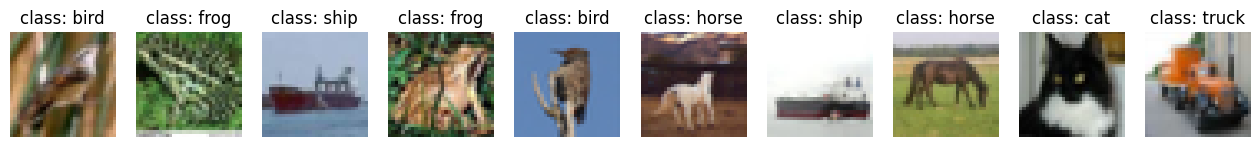

In [39]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=classes,
                      seed=None)

### Turn custom loaded images into DataLoader's

In [ ]:
# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_custom, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

train_dataloader_simple

### Model1: Create TinyVGG model class

In [41]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data_custom.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

In [43]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 32, 32]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 10, 32, 32]           280
│    └─ReLU: 2-2                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 10, 32, 32]           910
│    └─ReLU: 2-4                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 10, 16, 16]           --
├─Sequential: 1-2                        [1, 10, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 10, 16, 16]           910
│    └─ReLU: 2-7                         [1, 10, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 10, 16, 16]           910
│    └─ReLU: 2-9                         [1, 10, 16, 16]           --
│    └─MaxPool2d: 2-10                   [1, 10, 8, 8]             --
├─Sequentia

### Create train & test loop functions

In [62]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [63]:
# Ở bài toán này thì không dùng
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Creating a train() function

In [ ]:
from tqdm.auto import tqdm

In [64]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Train Model 0

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data_custom.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

### Plot the loss curves of Model 0

In [ ]:
# Check the model_0_results keys
model_0_results.keys()

In [40]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    # test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    # test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    # plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    # plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(model_0_results)

### Model2: Transfer learning with base model - EfficientNet B0 (mở đóng băng 2 layer cuối)

In [74]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [75]:
train_data_custom_model2 = ImageFolderCustom(targ_dir=train_dir,
                                      labels=train_labels,
                                      transform=manual_transforms)
train_data_custom_model2

In [76]:
# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple_model2 = DataLoader(dataset=train_data_custom_model2, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

train_dataloader_simple_model2

Creating DataLoader's with batch size 32 and 4 workers.


In [77]:
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [78]:
summary(model=model_2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [79]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

In [80]:
# Sau đó mở lại vài layer cuối
# for param in model_2.features[7].parameters():   # Sequential(7)
#     param.requires_grad = False
for param in model_2.features[8].parameters():   # Conv2dNormActivation
    param.requires_grad = True
for param in model_2.classifier.parameters():    # classifier
    param.requires_grad = True

In [81]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of classes (one output unit for each class)
output_shape = len(classes)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [82]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32

In [83]:
print(device)

cuda


In [84]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_2_results = train(model=model_2, 
                        train_dataloader=train_dataloader_simple_model2,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6609 | train_acc: 0.7763 | 
Epoch: 2 | train_loss: 0.4784 | train_acc: 0.8363 | 
Epoch: 3 | train_loss: 0.4119 | train_acc: 0.8585 | 
Epoch: 4 | train_loss: 0.3692 | train_acc: 0.8709 | 
Epoch: 5 | train_loss: 0.3326 | train_acc: 0.8835 | 
Total training time: 434.579 seconds


In [85]:
# Check the model_0_results keys
model_2_results.keys()

dict_keys(['train_loss', 'train_acc'])

In [86]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    # test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    # test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    # plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    # plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

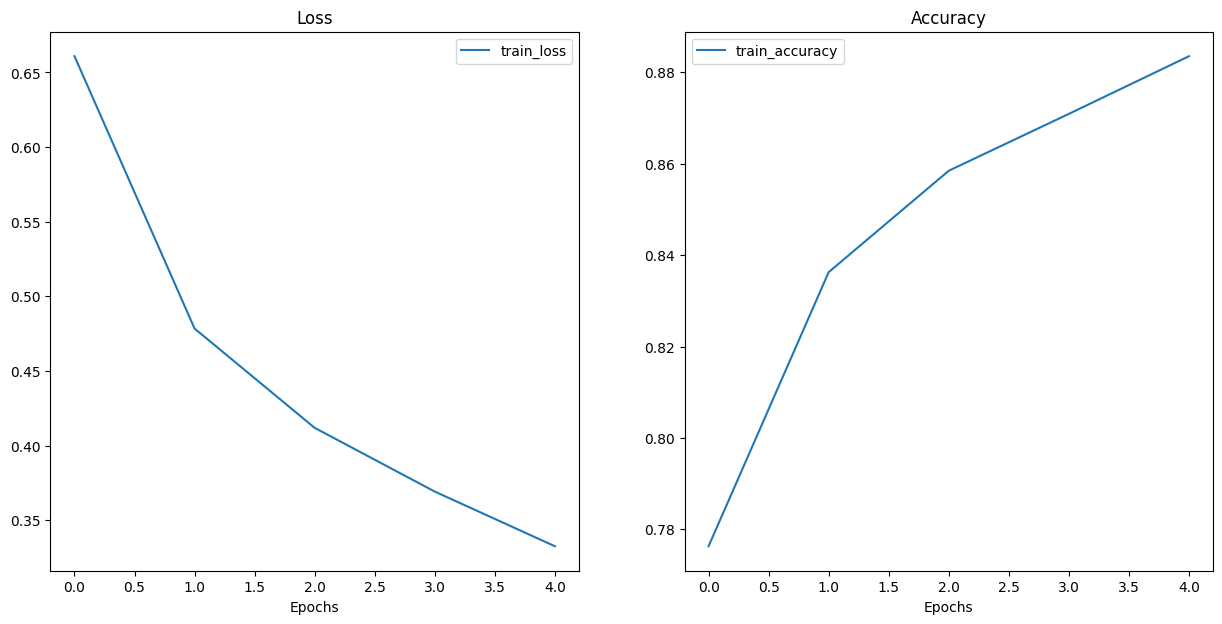

In [87]:
plot_loss_curves(model_2_results)

In [100]:
### =>>>>>>>>>>>>>>>> Model_2 đạt accuracy bằng 0.86900

### ### Model3: Transfer learning with base model - EfficientNet B0 (mở đóng băng tất cả layer)

In [149]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [150]:
train_data_custom_model3 = ImageFolderCustom(targ_dir=train_dir,
                                      labels=train_labels,
                                      transform=manual_transforms)
train_data_custom_model3

In [151]:
# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple_model3 = DataLoader(dataset=train_data_custom_model3, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

train_dataloader_simple_model3

Creating DataLoader's with batch size 32 and 4 workers.


In [152]:
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model_3 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [153]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_3.features.parameters():
    param.requires_grad = True

In [154]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of classes (one output unit for each class)
output_shape = len(classes)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [155]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_3, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [156]:
print(device)

cuda


In [157]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_3_results = train(model=model_3, 
                        train_dataloader=train_dataloader_simple_model3,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4490 | train_acc: 0.8495 | 
Epoch: 2 | train_loss: 0.2666 | train_acc: 0.9095 | 
Epoch: 3 | train_loss: 0.2098 | train_acc: 0.9288 | 
Epoch: 4 | train_loss: 0.1735 | train_acc: 0.9413 | 
Epoch: 5 | train_loss: 0.1486 | train_acc: 0.9483 | 
Total training time: 1320.409 seconds


In [158]:
# Check the model_0_results keys
model_3_results.keys()

dict_keys(['train_loss', 'train_acc'])

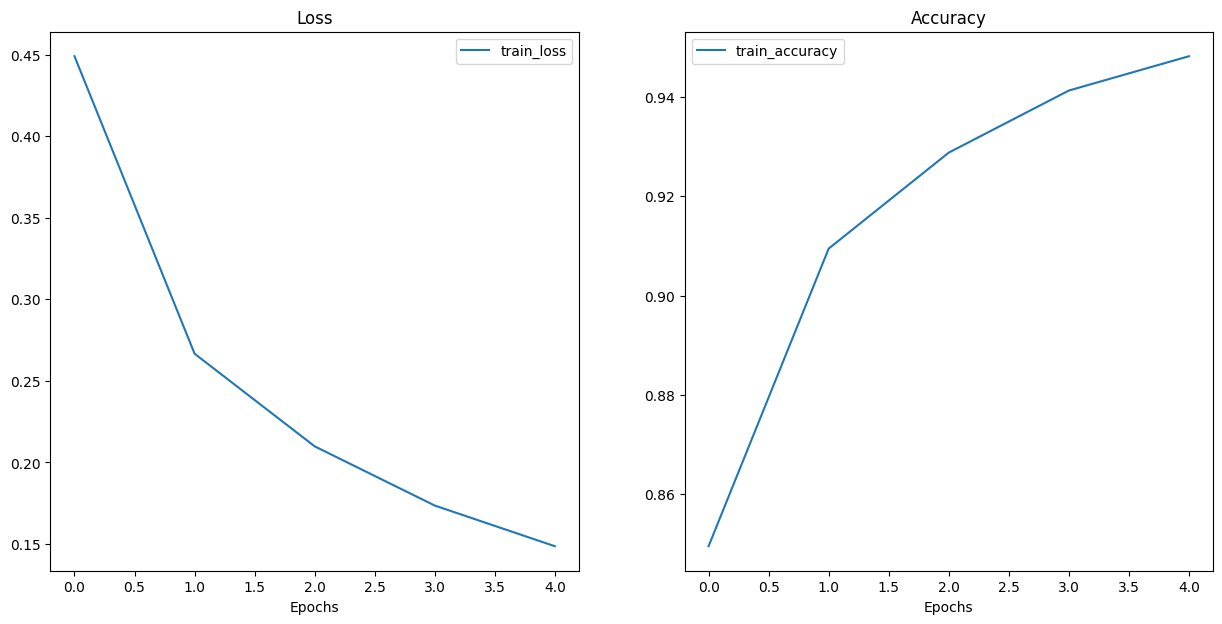

In [159]:
plot_loss_curves(model_3_results)

In [117]:
### =>>>>>>>>>>>>>>>> Model_3 đạt accuracy bằng 0.93350

### Predict test và ghi kết quả vào file submission.csv

In [ ]:
# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
number_submission = 4

In [ ]:
# Prepare the submission list
submission_data = []

# Predict each image
for idx, row in sample_submissions.iterrows():
    image_id = row['id']
    # Load the image
    image_path = test_dir / f"{image_id}.png"
    img = Image.open(image_path)

    # Apply the transformations to the image
    img = test_transforms(img)

    # Add a batch dimension
    img = img.unsqueeze(0)

    # Make the prediction
    model_3.eval()
    with torch.inference_mode():
        outputs = model_3(img.to(device))
        predicted = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
    
    # Get the predicted class label
    predicted_label = idx_to_class[predicted.item()]

    # Append the result to the submission list
    submission_data.append({'id': image_id, 'label': predicted_label})
    if int(image_id) % 10000 == 0:
        print(f"Done ảnh {image_id}")

# Convert the submission data to a DataFrame
submission_df = pd.DataFrame(submission_data)

# Save the submission file
number_submission = number_submission+1
submission_df.to_csv(f'/kaggle/working/submission{number_submission}.csv', index=False)

print(f"Submission file saved to 'submission{number_submission}.csv'.")

In [ ]:
submission_df.head()

In [ ]:
submission_df.shape

In [ ]:
df = pd.read_csv("submission5.csv")
df.head()

### Custom Test Dataset predict cùng lúc với batch_size=32 tận dụng GPU => nhanh hơn
### Sau đó ghi kết quả vào file submission.csv

In [195]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class TestDataset(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, labels: pd.DataFrame, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all .png images and sort them by filename (numerically)
        self.paths = sorted(pathlib.Path(targ_dir).glob("*.png"), key=lambda x: int(x.stem))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = classes, class_to_idx
        # Set up labels
        self.labels = labels

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        image_id = int(self.labels.iloc[index]['id'])
        image_path = self.paths[index]
        img = Image.open(image_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, image_id  # trả về ảnh và id

In [177]:
test_data_custom_model3 = TestDataset(targ_dir=test_dir,
                                      labels=sample_submissions,
                                      transform=manual_transforms)
test_data_custom_model3

In [178]:
# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
test_dataloader_simple_model3 = DataLoader(dataset=test_data_custom_model3, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple_model3

Creating DataLoader's with batch size 32 and 4 workers.


In [179]:
number_submission = 4
submission_data = []

model_3.eval()
with torch.inference_mode():
    for imgs, image_ids in test_dataloader_simple_model3:
        outputs = model_3(imgs.to(device))
        preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

        for img_id, pred in zip(image_ids, preds):
            predicted_label = idx_to_class[pred.item()]
            submission_data.append({'id': int(img_id), 'label': predicted_label})
            if(int(img_id) % 10000 == 0):
                print(f"Done ảnh {img_id}")
                
# Convert the submission data to a DataFrame
submission_df = pd.DataFrame(submission_data)

# Save the submission file
number_submission = number_submission+1
submission_df.to_csv(f'/kaggle/working/submission{number_submission}.csv', index=False)

print(f"Submission file saved to 'submission{number_submission}.csv'.")

Done ảnh 230000
Done ảnh 130000
Done ảnh 300000
Done ảnh 150000
Done ảnh 290000
Done ảnh 220000
Done ảnh 280000
Done ảnh 50000
Done ảnh 180000
Done ảnh 40000
Done ảnh 190000
Done ảnh 140000
Done ảnh 200000
Done ảnh 90000
Done ảnh 10000
Done ảnh 110000
Done ảnh 70000
Done ảnh 60000
Done ảnh 120000
Done ảnh 210000
Done ảnh 170000
Done ảnh 20000
Done ảnh 160000
Done ảnh 100000
Done ảnh 260000
Done ảnh 240000
Done ảnh 250000
Done ảnh 30000
Done ảnh 270000
Done ảnh 80000
Submission file saved to 'submission5.csv'.


In [180]:
submission_df.shape

(300000, 2)

In [196]:
df1 = pd.read_csv("submission6.csv")
df1.head()

,id,label
0,1,deer
1,2,airplane
2,3,automobile
3,4,ship
4,5,airplane
